#  spectra for AuxTel and Equivalent width with Specutils For Holograms

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : April 7th  2021
- update : April 15th 2021 : get equivalent width with specutils, including stat error with bootstrap
- update : April 16th 2021 : write eqw in csv file after correcting important bugs
- update : April 17th 2021 : plot eqw vs time
- version v1.0

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [3]:
from datetime import datetime,date

In [4]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [5]:
string_date

'2021-04-29'

In [6]:
from iminuit import Minuit
import iminuit

In [7]:
iminuit.__version__

'2.2.0'

In [8]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [9]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [10]:
from time import sleep

In [11]:
from astropy.time import Time
import astropy.units as u

# Function

In [12]:
def file_target(filename):
    m=re.findall('^Cor_holo4_003_.*_(.*)_[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*[.]fits$',filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []

# Logbook for file selection

In [13]:
filename_logbook='logbooks/auxtellogbook_2021_v1.2.csv'

In [14]:
df=pd.read_csv(filename_logbook,index_col=None)

In [15]:
pd.set_option('display.max_rows', None)

In [16]:
df

Unnamed: 0  index                     date  \
0            0      0  2021-02-17T01:45:09.091   
1            1      1  2021-02-17T03:37:12.647   
2            2      2  2021-02-18T07:25:02.387   
3            3      3  2021-02-18T07:25:46.560   
4            4      4  2021-02-18T07:26:07.146   
5            5      5  2021-02-18T07:26:18.957   
6            6      6  2021-02-18T07:26:43.049   
7            7      7  2021-02-18T07:26:51.615   
8            8      8  2021-02-18T07:27:00.190   
9            9      9  2021-02-18T07:27:53.863   
10          10     10  2021-02-18T07:29:41.903   
11          11     11  2021-02-19T05:53:27.926   
12          12     12  2021-02-19T05:55:59.153   
13          13     13  2021-02-19T05:56:26.421   
14          14     14  2021-02-19T05:59:48.510   
15          15     15  2021-02-19T06:02:10.932   
16          16     16  2021-02-19T06:03:07.565   
17          17     17  2021-02-19T06:03:51.105   
18          18     18  2021-02-19T06:04:27.300   
19          19     19  2021-02-19T06:05:05.010   
20          20     20  2021-02-19T06:06:29.575   
21          21     21  2021-02-19T06:06:53.561   
22          22     22  2021-02-19T06:07:09.034   
23          23     23  2021-02-19T06:07:49.989   
24          24     24  2021-02-19T06:09:04.533   
25          25     25  2021-02-19T06:09:36.863   
26          26     26  2021-02-19T06:11:51.450   
27          27     27  2021-02-19T06:12:39.359   
28          28     28  2021-02-19T06:13:21.360   
29          29     29  2021-02-19T06:13:36.394   
30          30     30  2021-02-19T06:13:43.043   
31          31     31  2021-02-19T06:13:50.035   
32          32     32  2021-02-19T06:13:57.849   
33          33     33  2021-02-19T06:14:06.963   
34          34     34  2021-02-19T06:14:16.655   
35          35     35  2021-02-19T06:14:25.695   
36          36     36  2021-02-19T06:14:35.269   
37          37     37  2021-02-19T06:15:14.640   
38          38     38  2021-02-19T06:15:29.988   
39          39     39  2021-02-19T06:15:42.966   
40          40     40  2021-02-19T06:16:00.336   
41          41     41  2021-02-19T06:16:42.390   
42          42     42  2021-02-19T06:18:37.431   
43          43     43  2021-02-19T06:25:48.342   
44          44     44  2021-02-19T06:26:07.604   
45          45     45  2021-02-19T06:26:35.551   
46          46     46  2021-02-19T06:28:33.570   
47          47     47  2021-02-19T06:29:01.054   
48          48     48  2021-03-12T01:01:30.478   
49          49     49  2021-03-12T01:02:00.570   
50          50     50  2021-03-12T01:02:28.770   
51          51     51  2021-03-12T01:23:46.224   
52          52     52  2021-03-12T01:24:21.169   
53          53     53  2021-03-12T01:24:42.413   
54          54     54  2021-03-12T02:45:25.087   
55          55     55  2021-03-12T02:47:31.346   
56          56     56  2021-03-12T02:48:00.283   
57          57     57  2021-03-12T02:48:29.927   
58          58     58  2021-03-12T02:48:58.831   
59          59     59  2021-03-12T02:49:27.942   
60          60     60  2021-03-12T02:49:57.673   
61          61     61  2021-03-12T02:50:27.091   
62          62     62  2021-03-12T02:50:56.136   
63          63     63  2021-03-12T02:51:25.196   
64          64     64  2021-03-12T02:51:54.248   
65          65     65  2021-03-12T02:52:23.352   
66          66     66  2021-03-12T02:52:52.463   
67          67     67  2021-03-12T02:53:21.563   
68          68     68  2021-03-12T02:53:51.050   
69          69     69  2021-03-12T02:54:20.571   
70          70     70  2021-03-12T02:54:49.518   
71          71     71  2021-03-12T02:55:18.628   
72          72     72  2021-03-12T02:55:47.723   
73          73     73  2021-03-12T02:56:17.274   
74          74     74  2021-03-12T02:56:46.922   
75          75     75  2021-03-12T02:57:15.859   

                                                 path  \
0   /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans   
1   /sps/lsst/groups/auxtel/data/2021/h

# Selection of input file

In [17]:
df_good=df[df["quality"]==1]

In [18]:
for spectra_file in df_good["file"]:
    print(spectra_file)

Cor_holo4_003_NGC4755_2021-02-17_350.fits
Cor_holo4_003_NGC4755_2021-02-17_351.fits
Cor_holo4_003_NGC4755_2021-02-17_352.fits
Cor_holo4_003_NGC4755_2021-02-17_353.fits
Cor_holo4_003_NGC4755_2021-02-17_354.fits
Cor_holo4_003_NGC4755_2021-02-17_355.fits
Cor_holo4_003_NGC4755_2021-02-17_356.fits
Cor_holo4_003_NGC4755_2021-02-17_357.fits
Cor_holo4_003_NGC4755_2021-02-17_358.fits
Cor_holo4_003_RG610_HD60753_2021-02-18_556.fits
Cor_holo4_003_RG610_HD60753_2021-02-18_559.fits
Cor_holo4_003_RG610_HD60753_2021-02-18_560.fits
Cor_holo4_003_RG610_HD60753_2021-02-18_561.fits
Cor_holo4_003_RG610_HD60753_2021-02-18_562.fits
Cor_holo4_003_RG610_HD60753_2021-02-18_563.fits
Cor_holo4_003_RG610_HD60753_2021-02-18_564.fits
Cor_holo4_003_empty_HD60753_2021-02-18_566.fits
Cor_holo4_003_empty_HD60753_2021-02-18_567.fits
Cor_holo4_003_empty_HD60753_2021-02-18_568.fits
Cor_holo4_003_empty_HD60753_2021-02-18_569.fits
Cor_holo4_003_empty_HD60753_2021-02-18_570.fits
Cor_holo4_003_empty_HD60753_2021-02-18_571.fit

In [19]:
dir_spectra="outputs"

In [20]:
!ls outputs

Cor_holo4_003_NGC4755_2021-02-17_350_lines.csv
Cor_holo4_003_NGC4755_2021-02-17_350_spectrogram.fits
Cor_holo4_003_NGC4755_2021-02-17_350_spectrum.fits
Cor_holo4_003_NGC4755_2021-02-17_350_table.csv
Cor_holo4_003_NGC4755_2021-02-17_351_lines.csv
Cor_holo4_003_NGC4755_2021-02-17_351_spectrogram.fits
Cor_holo4_003_NGC4755_2021-02-17_351_spectrum.fits
Cor_holo4_003_NGC4755_2021-02-17_351_table.csv
Cor_holo4_003_NGC4755_2021-02-17_352_lines.csv
Cor_holo4_003_NGC4755_2021-02-17_352_spectrogram.fits
Cor_holo4_003_NGC4755_2021-02-17_352_spectrum.fits
Cor_holo4_003_NGC4755_2021-02-17_352_table.csv
Cor_holo4_003_NGC4755_2021-02-17_353_lines.csv
Cor_holo4_003_NGC4755_2021-02-17_353_spectrogram.fits
Cor_holo4_003_NGC4755_2021-02-17_353_spectrum.fits
Cor_holo4_003_NGC4755_2021-02-17_353_table.csv
Cor_holo4_003_NGC4755_2021-02-17_354_lines.csv
Cor_holo4_003_NGC4755_2021-02-17_354_spectrogram.fits
Cor_holo4_003_NGC4755_2021-02-17_354_spectrum.fits
Cor_holo4_003_NGC4755_2021-02-17_354_table.csv
Cor_h

In [21]:
all_files=os.listdir(dir_spectra)

In [22]:
all_spectra_files = []
for filename in all_files:
    if re.search("_spectrum.fits$",filename):
        all_spectra_files.append(filename)
N=len(all_spectra_files)

In [23]:
all_good_spectra_spectrum_files=[]

idx=0
for good_spectra_file in df_good["file"]:
    good_spectra_spectrum_file = good_spectra_file.split(".")[0]+"_spectrum.fits"
    if good_spectra_spectrum_file in all_spectra_files:
        print(idx,") : found {}".format(good_spectra_spectrum_file))
        all_good_spectra_spectrum_files.append(good_spectra_spectrum_file)
        idx+=1
    

0 ) : found Cor_holo4_003_NGC4755_2021-02-17_350_spectrum.fits
1 ) : found Cor_holo4_003_NGC4755_2021-02-17_351_spectrum.fits
2 ) : found Cor_holo4_003_NGC4755_2021-02-17_352_spectrum.fits
3 ) : found Cor_holo4_003_NGC4755_2021-02-17_353_spectrum.fits
4 ) : found Cor_holo4_003_NGC4755_2021-02-17_354_spectrum.fits
5 ) : found Cor_holo4_003_NGC4755_2021-02-17_355_spectrum.fits
6 ) : found Cor_holo4_003_NGC4755_2021-02-17_356_spectrum.fits
7 ) : found Cor_holo4_003_NGC4755_2021-02-17_357_spectrum.fits
8 ) : found Cor_holo4_003_NGC4755_2021-02-17_358_spectrum.fits
9 ) : found Cor_holo4_003_RG610_HD60753_2021-02-18_556_spectrum.fits
10 ) : found Cor_holo4_003_RG610_HD60753_2021-02-18_559_spectrum.fits
11 ) : found Cor_holo4_003_RG610_HD60753_2021-02-18_560_spectrum.fits
12 ) : found Cor_holo4_003_RG610_HD60753_2021-02-18_561_spectrum.fits
13 ) : found Cor_holo4_003_RG610_HD60753_2021-02-18_562_spectrum.fits
14 ) : found Cor_holo4_003_RG610_HD60753_2021-02-18_563_spectrum.fits
15 ) : found C

0 ) Cor_holo4_003_NGC4755_2021-02-17_350_spectrum.fits   outputs/Cor_holo4_003_NGC4755_2021-02-17_350_spectrum.fits


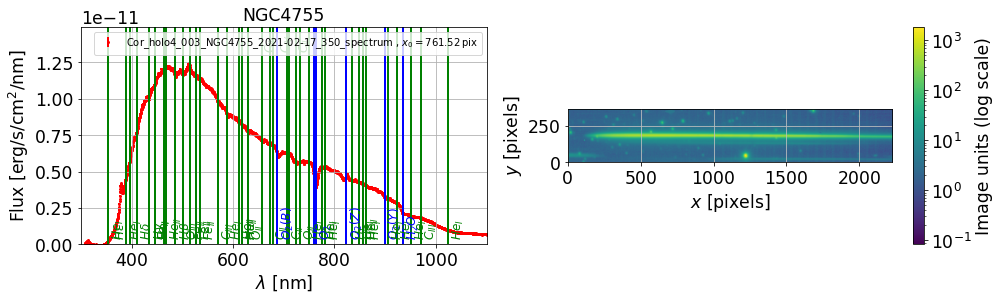

1 ) Cor_holo4_003_NGC4755_2021-02-17_351_spectrum.fits   outputs/Cor_holo4_003_NGC4755_2021-02-17_351_spectrum.fits


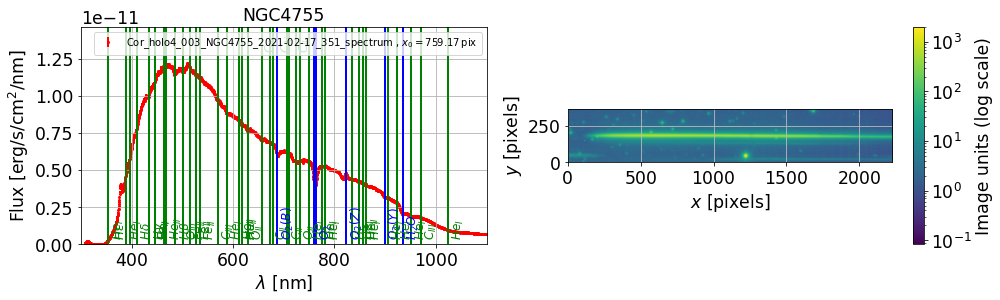

2 ) Cor_holo4_003_NGC4755_2021-02-17_352_spectrum.fits   outputs/Cor_holo4_003_NGC4755_2021-02-17_352_spectrum.fits


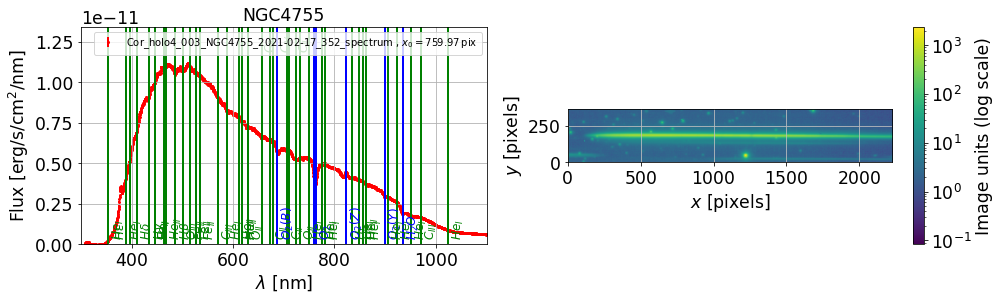

3 ) Cor_holo4_003_NGC4755_2021-02-17_353_spectrum.fits   outputs/Cor_holo4_003_NGC4755_2021-02-17_353_spectrum.fits


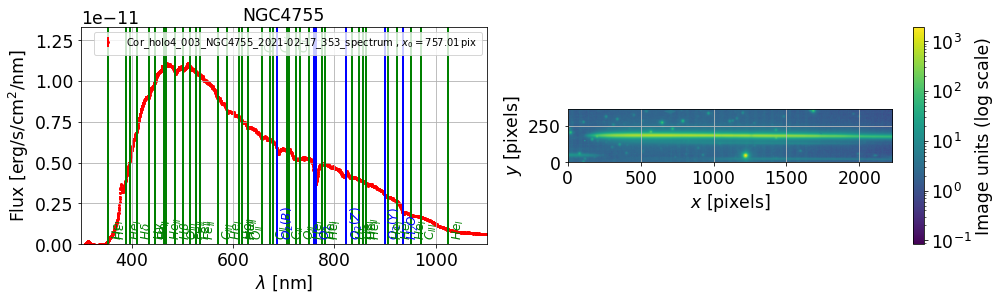

4 ) Cor_holo4_003_NGC4755_2021-02-17_354_spectrum.fits   outputs/Cor_holo4_003_NGC4755_2021-02-17_354_spectrum.fits


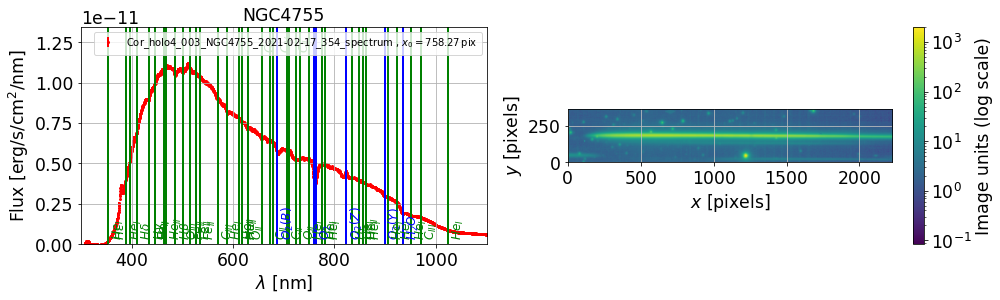

5 ) Cor_holo4_003_NGC4755_2021-02-17_355_spectrum.fits   outputs/Cor_holo4_003_NGC4755_2021-02-17_355_spectrum.fits


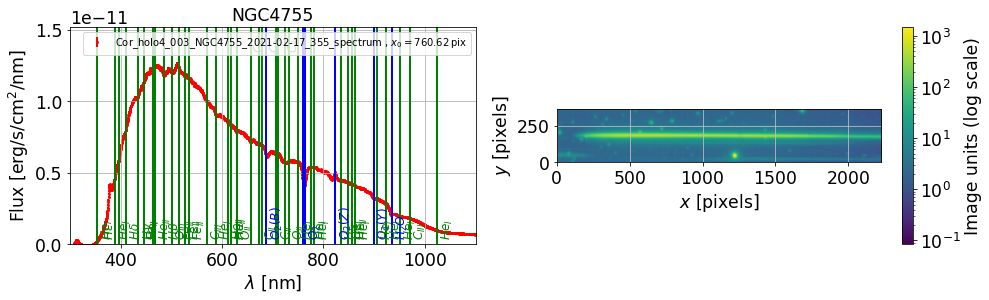

6 ) Cor_holo4_003_NGC4755_2021-02-17_356_spectrum.fits   outputs/Cor_holo4_003_NGC4755_2021-02-17_356_spectrum.fits


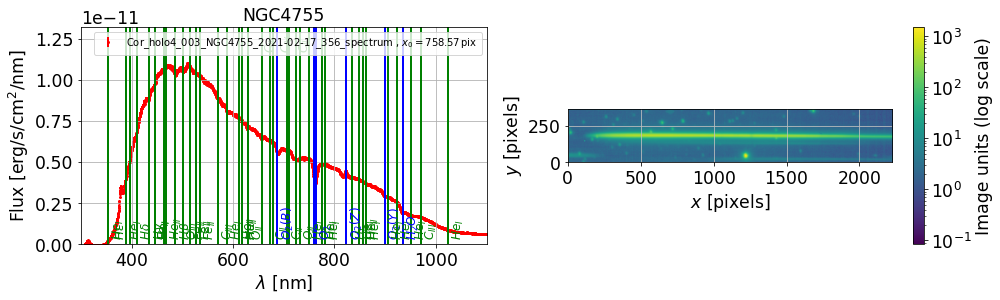

7 ) Cor_holo4_003_NGC4755_2021-02-17_357_spectrum.fits   outputs/Cor_holo4_003_NGC4755_2021-02-17_357_spectrum.fits


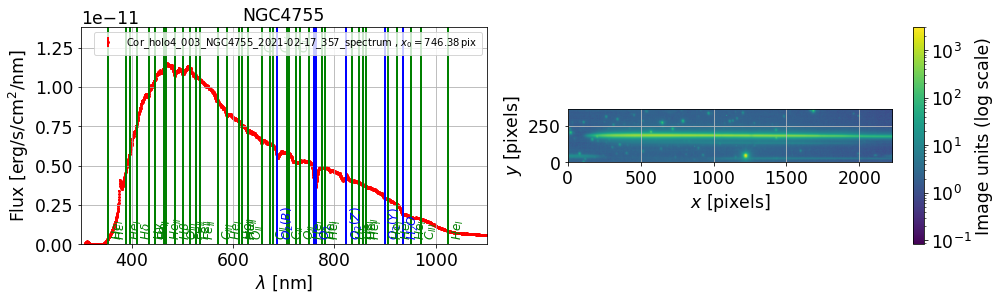

8 ) Cor_holo4_003_NGC4755_2021-02-17_358_spectrum.fits   outputs/Cor_holo4_003_NGC4755_2021-02-17_358_spectrum.fits


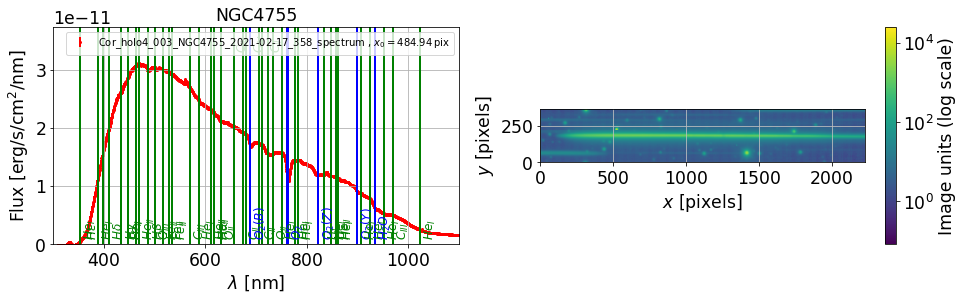

9 ) Cor_holo4_003_RG610_HD60753_2021-02-18_556_spectrum.fits   outputs/Cor_holo4_003_RG610_HD60753_2021-02-18_556_spectrum.fits


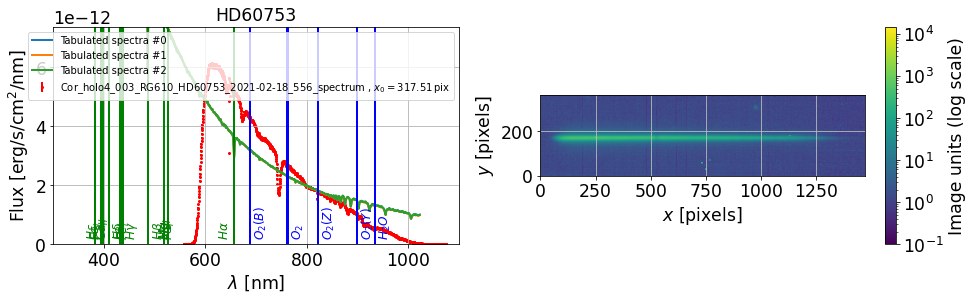

10 ) Cor_holo4_003_RG610_HD60753_2021-02-18_559_spectrum.fits   outputs/Cor_holo4_003_RG610_HD60753_2021-02-18_559_spectrum.fits


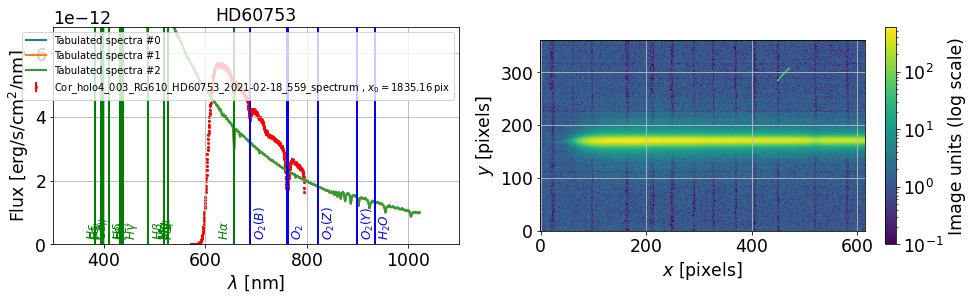

11 ) Cor_holo4_003_RG610_HD60753_2021-02-18_560_spectrum.fits   outputs/Cor_holo4_003_RG610_HD60753_2021-02-18_560_spectrum.fits


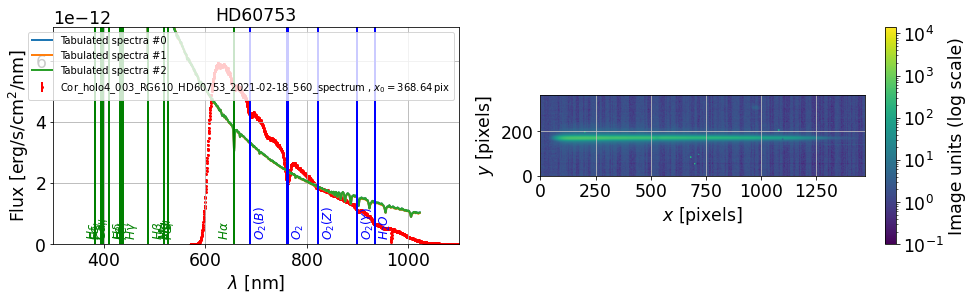

12 ) Cor_holo4_003_RG610_HD60753_2021-02-18_561_spectrum.fits   outputs/Cor_holo4_003_RG610_HD60753_2021-02-18_561_spectrum.fits


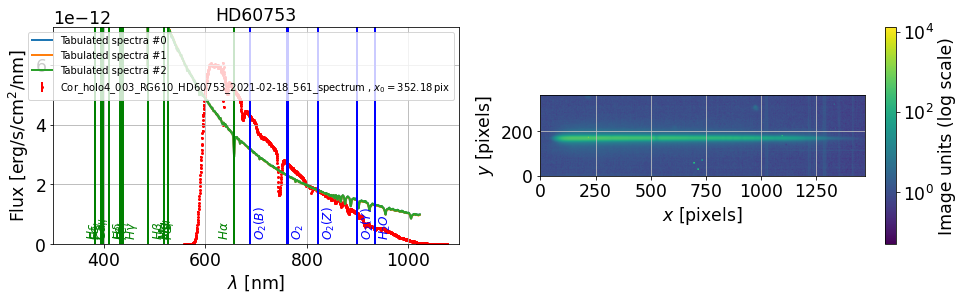

13 ) Cor_holo4_003_RG610_HD60753_2021-02-18_562_spectrum.fits   outputs/Cor_holo4_003_RG610_HD60753_2021-02-18_562_spectrum.fits


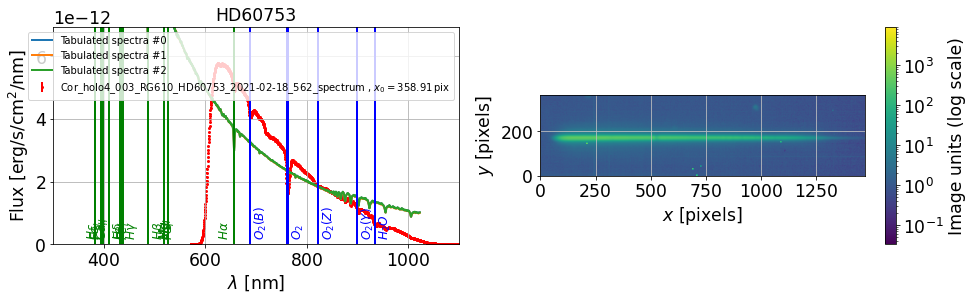

14 ) Cor_holo4_003_RG610_HD60753_2021-02-18_563_spectrum.fits   outputs/Cor_holo4_003_RG610_HD60753_2021-02-18_563_spectrum.fits


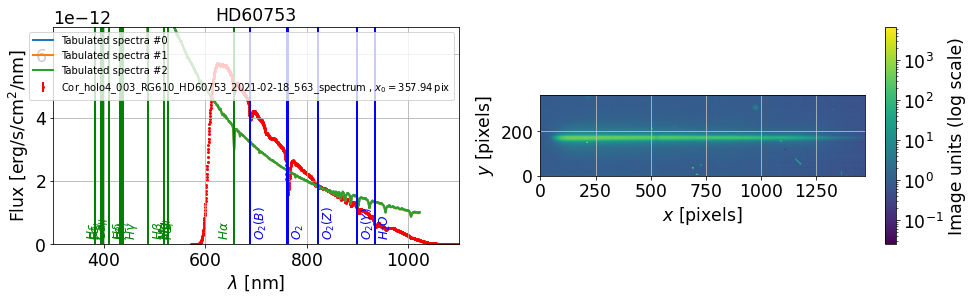

15 ) Cor_holo4_003_RG610_HD60753_2021-02-18_564_spectrum.fits   outputs/Cor_holo4_003_RG610_HD60753_2021-02-18_564_spectrum.fits


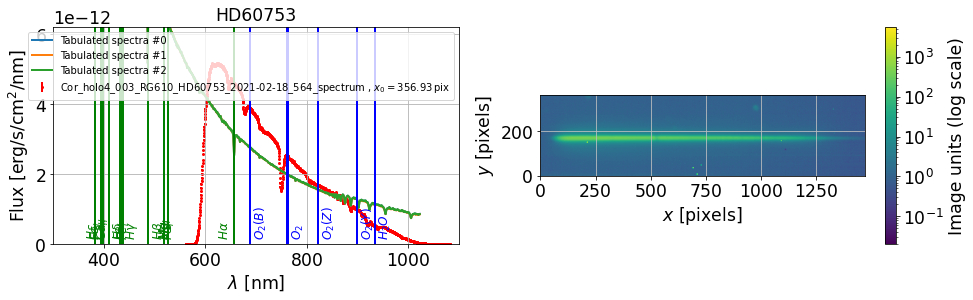

16 ) Cor_holo4_003_empty_HD60753_2021-02-18_566_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_566_spectrum.fits


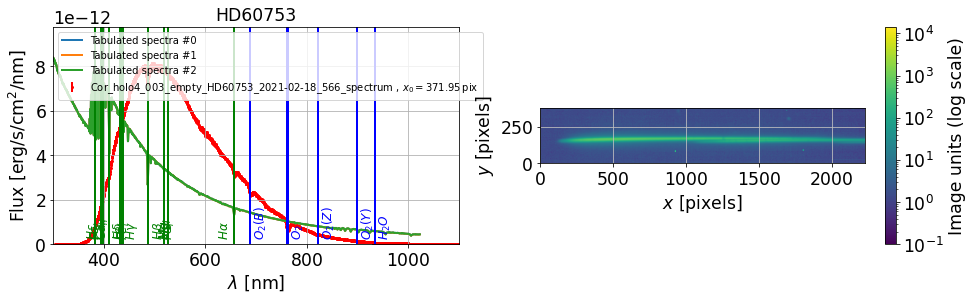

17 ) Cor_holo4_003_empty_HD60753_2021-02-18_568_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_568_spectrum.fits


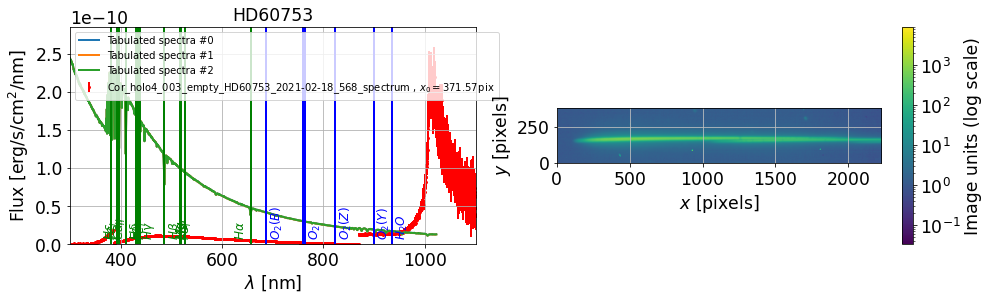

18 ) Cor_holo4_003_empty_HD60753_2021-02-18_569_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_569_spectrum.fits


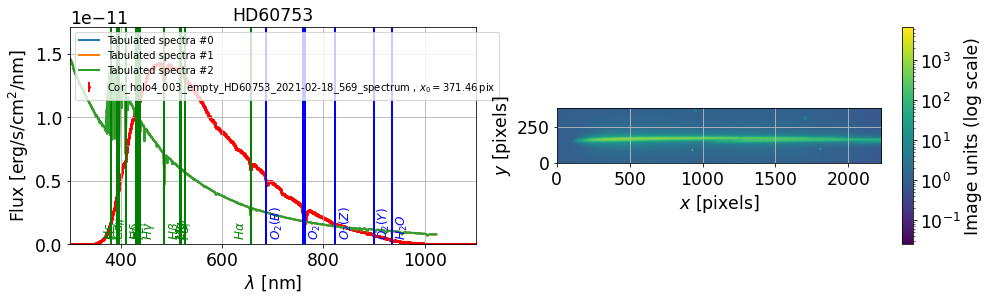

19 ) Cor_holo4_003_empty_HD60753_2021-02-18_570_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_570_spectrum.fits


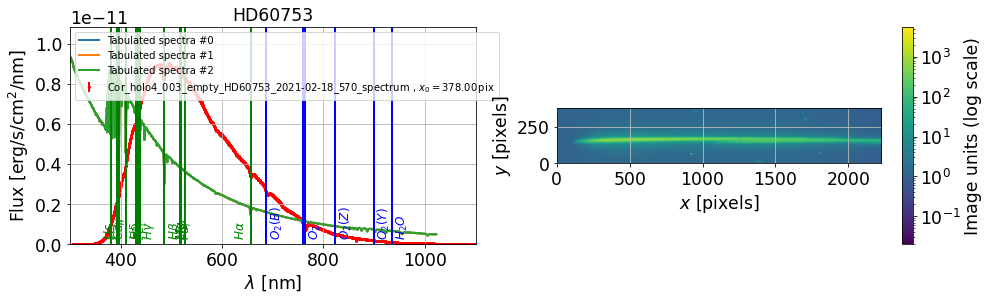

20 ) Cor_holo4_003_empty_HD60753_2021-02-18_572_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_572_spectrum.fits


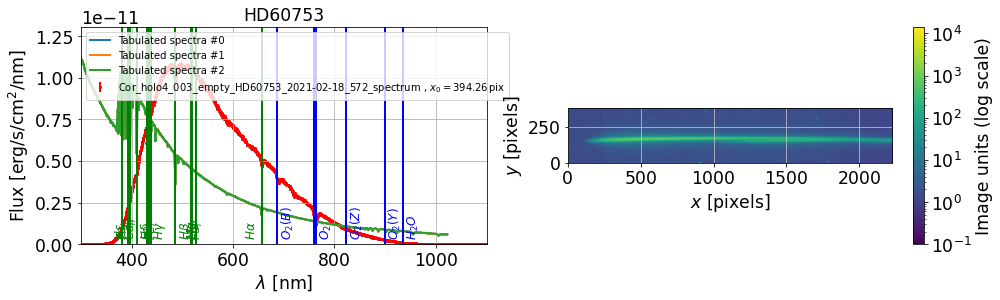

21 ) Cor_holo4_003_empty_HD60753_2021-02-18_573_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_573_spectrum.fits


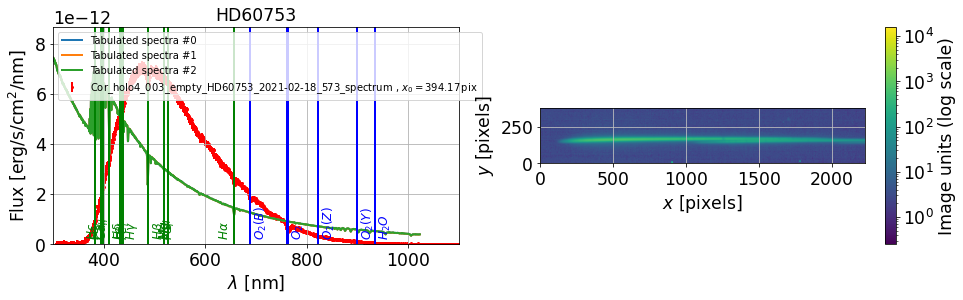

22 ) Cor_holo4_003_empty_HD60753_2021-02-18_574_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_574_spectrum.fits


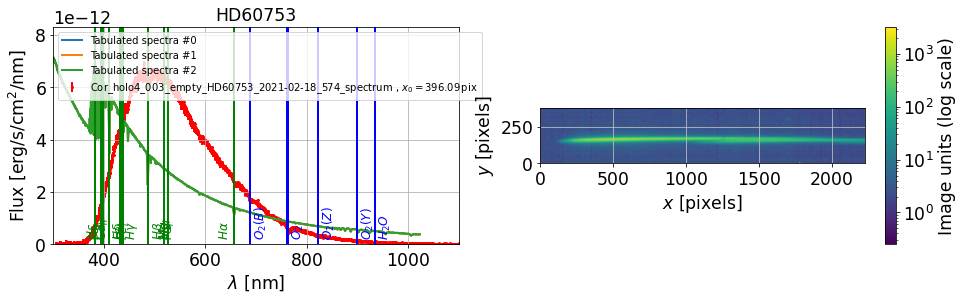

23 ) Cor_holo4_003_empty_HD60753_2021-02-18_575_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_575_spectrum.fits


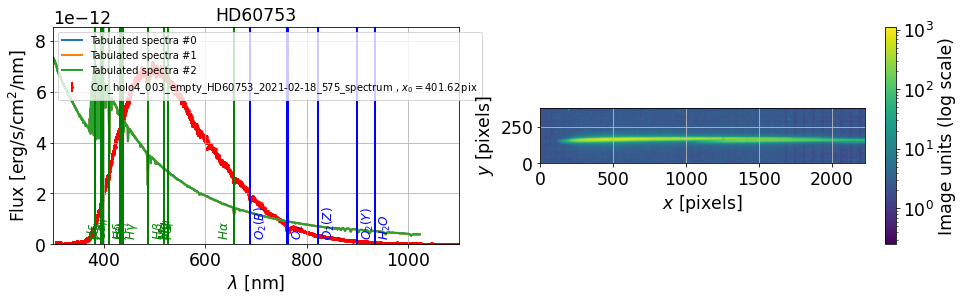

24 ) Cor_holo4_003_empty_HD60753_2021-02-18_576_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_576_spectrum.fits


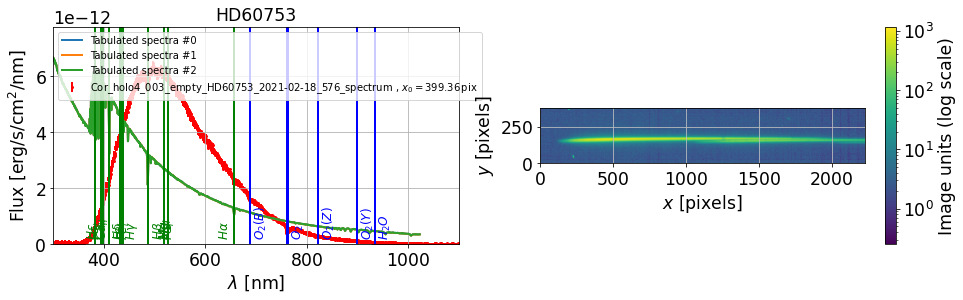

25 ) Cor_holo4_003_empty_HD60753_2021-02-18_577_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_577_spectrum.fits


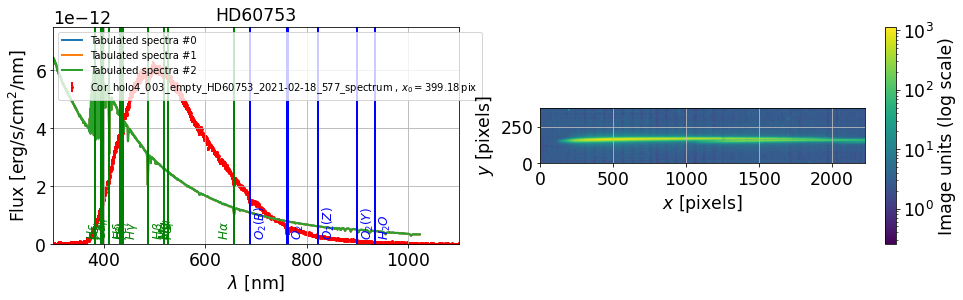

26 ) Cor_holo4_003_empty_HD60753_2021-02-18_578_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_578_spectrum.fits


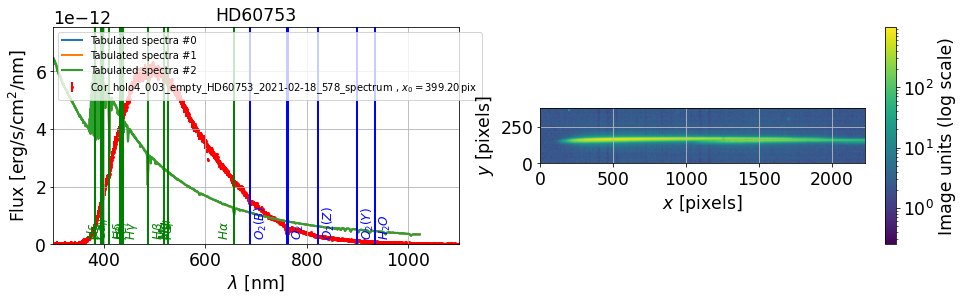

27 ) Cor_holo4_003_empty_HD60753_2021-02-18_579_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_579_spectrum.fits


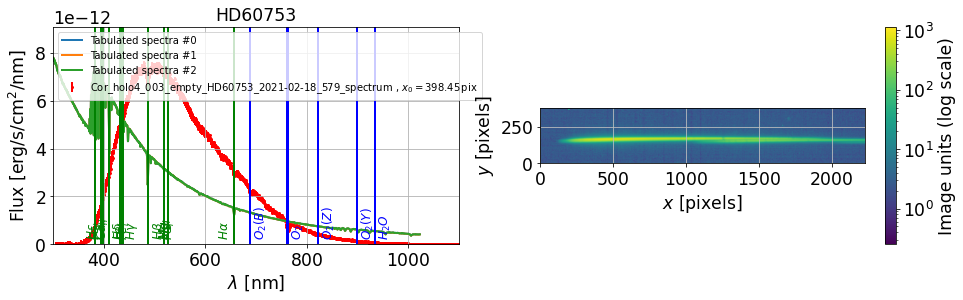

28 ) Cor_holo4_003_empty_HD60753_2021-02-18_580_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_580_spectrum.fits


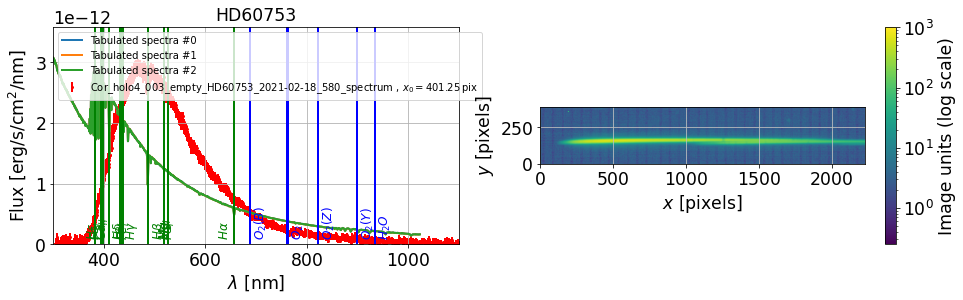

29 ) Cor_holo4_003_empty_HD60753_2021-02-18_581_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_581_spectrum.fits


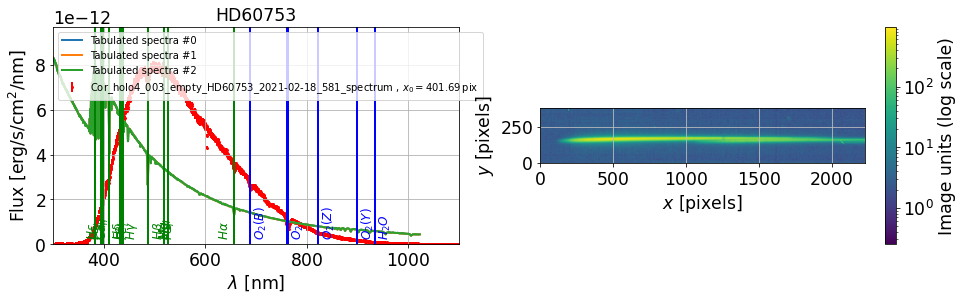

30 ) Cor_holo4_003_empty_HD60753_2021-02-18_582_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_582_spectrum.fits


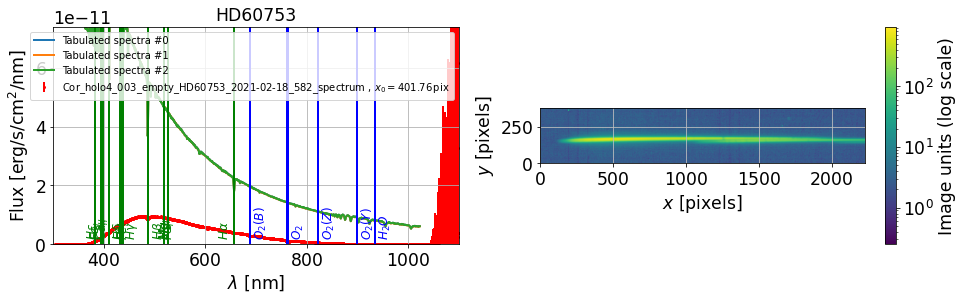

31 ) Cor_holo4_003_empty_HD60753_2021-02-18_583_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_583_spectrum.fits


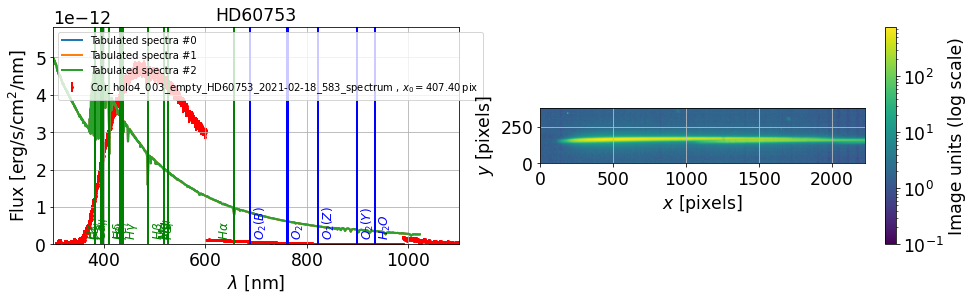

32 ) Cor_holo4_003_empty_HD60753_2021-02-18_584_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_584_spectrum.fits


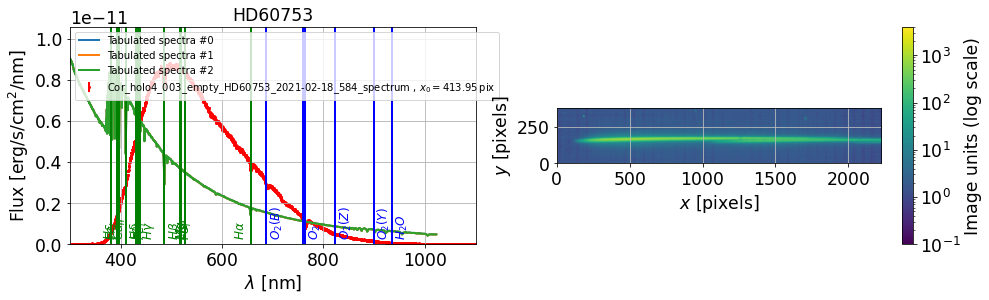

33 ) Cor_holo4_003_empty_HD60753_2021-02-18_585_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_585_spectrum.fits


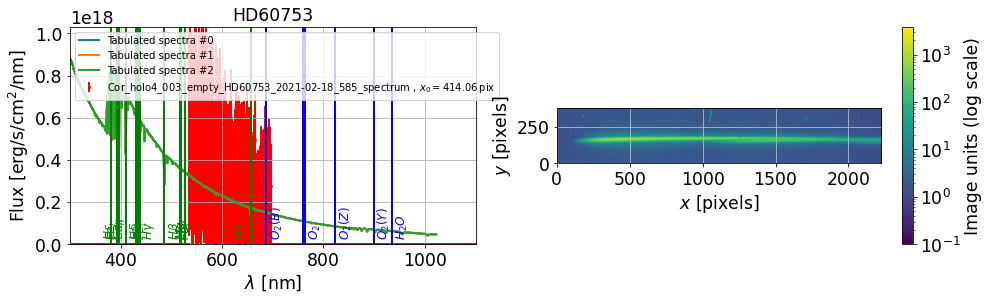

34 ) Cor_holo4_003_empty_HD60753_2021-02-18_586_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_586_spectrum.fits


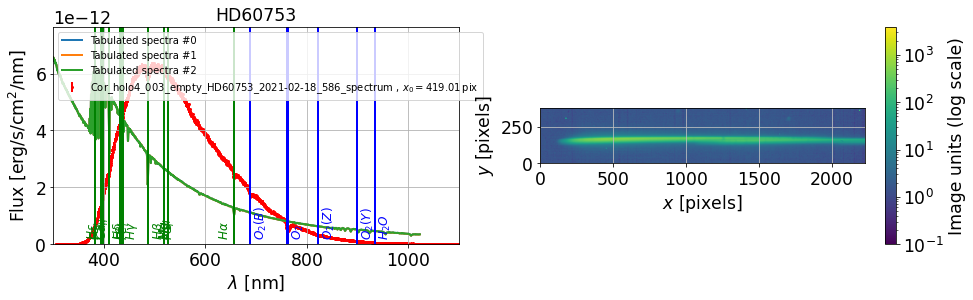

35 ) Cor_holo4_003_empty_HD60753_2021-02-18_587_spectrum.fits   outputs/Cor_holo4_003_empty_HD60753_2021-02-18_587_spectrum.fits


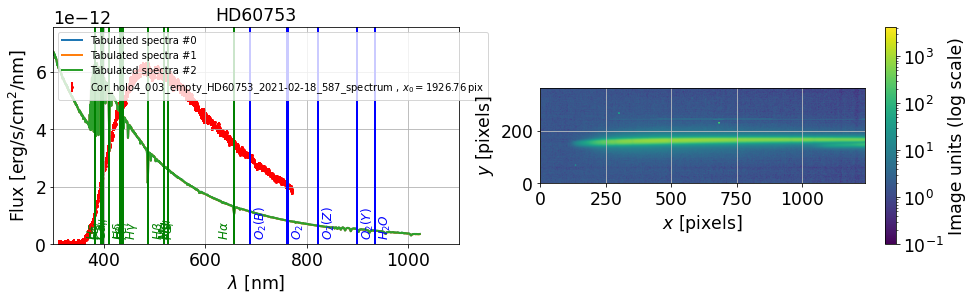

36 ) Cor_holo4_003_RG610_HD75519_2021-03-11_191_spectrum.fits   outputs/Cor_holo4_003_RG610_HD75519_2021-03-11_191_spectrum.fits


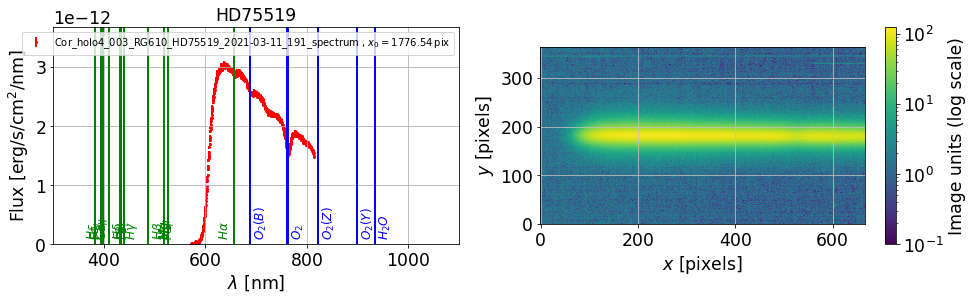

37 ) Cor_holo4_003_RG610_HD75519_2021-03-11_192_spectrum.fits   outputs/Cor_holo4_003_RG610_HD75519_2021-03-11_192_spectrum.fits


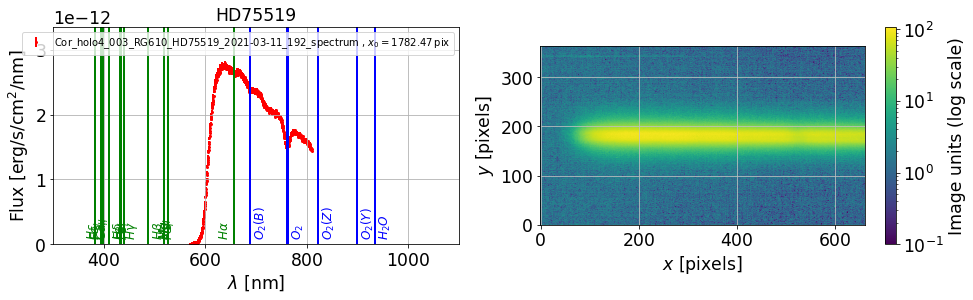

38 ) Cor_holo4_003_RG610_HD75519_2021-03-11_193_spectrum.fits   outputs/Cor_holo4_003_RG610_HD75519_2021-03-11_193_spectrum.fits


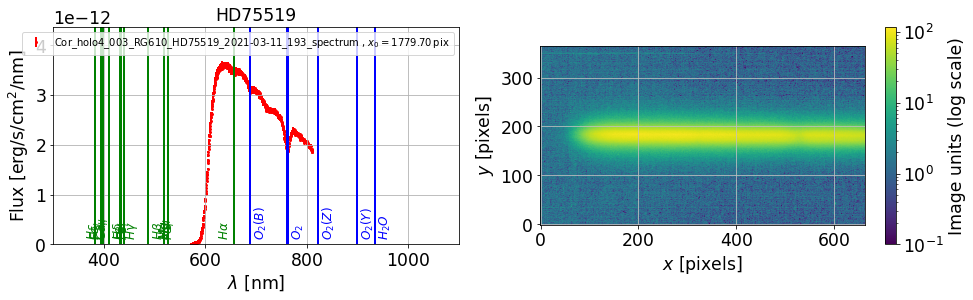

39 ) Cor_holo4_003_RG610_HD75519_2021-03-11_292_spectrum.fits   outputs/Cor_holo4_003_RG610_HD75519_2021-03-11_292_spectrum.fits


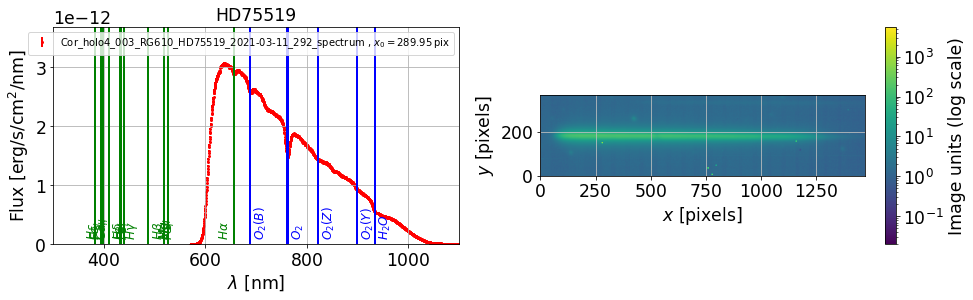

40 ) Cor_holo4_003_RG610_HD75519_2021-03-11_293_spectrum.fits   outputs/Cor_holo4_003_RG610_HD75519_2021-03-11_293_spectrum.fits


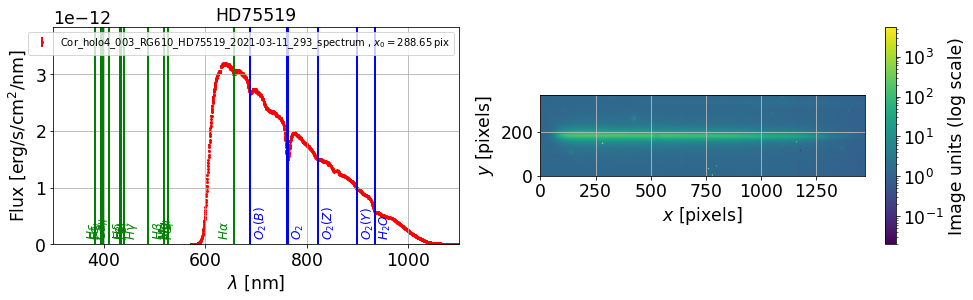

41 ) Cor_holo4_003_RG610_HD75519_2021-03-11_294_spectrum.fits   outputs/Cor_holo4_003_RG610_HD75519_2021-03-11_294_spectrum.fits


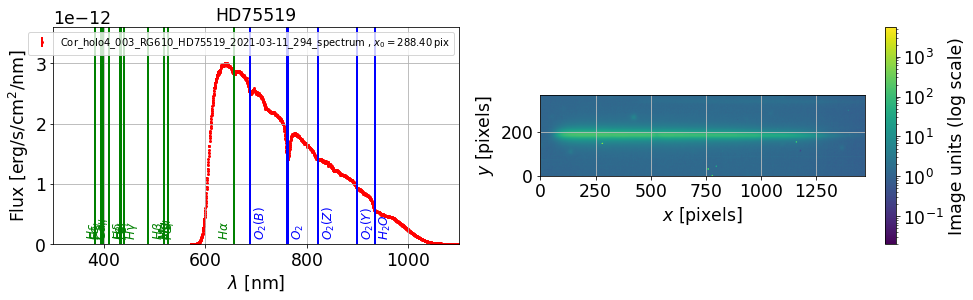

42 ) Cor_holo4_003_RG610_HD75519_2021-03-11_295_spectrum.fits   outputs/Cor_holo4_003_RG610_HD75519_2021-03-11_295_spectrum.fits


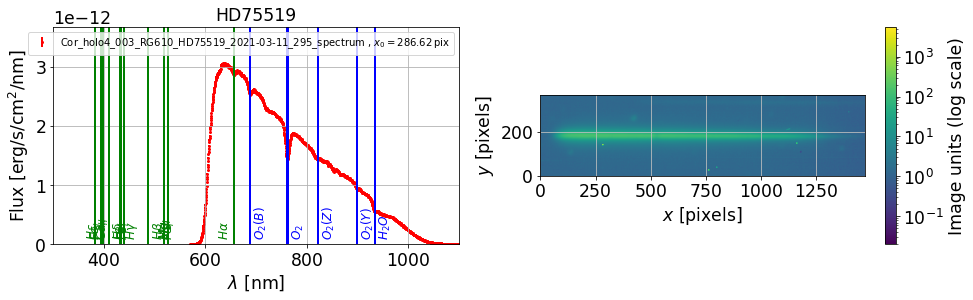

43 ) Cor_holo4_003_RG610_HD75519_2021-03-11_296_spectrum.fits   outputs/Cor_holo4_003_RG610_HD75519_2021-03-11_296_spectrum.fits


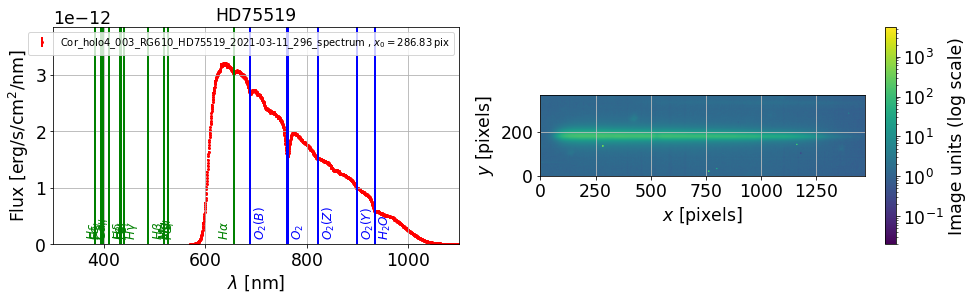

In [24]:
parameters.DISPLAY=False

infos = []

idx=0
for filename in all_good_spectra_spectrum_files:
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    fullfilename = os.path.join(dir_spectra,filename)
    
    print(idx,")",filename," ",fullfilename)
    
    
    #try:
    #    s=Spectrum(fullfilename, config="config/auxtel_quicklook.ini")
    #    print("Success First Connection with file "+ fullfilename)
    #    break           
    #except requests.exceptions.ConnectionError:
    #except:
    #    print("Connection refused, will retry")
    #    sleep(5)
    #    try:
    #        print("try connection again ")    
    #        s=Spectrum(fullfilename, config="config/auxtel_quicklook.ini")
    #        print("Success Second Connection ")
    #        break
        
        #except requests.exceptions.ConnectionError:
    #    except:
    #        print("Connection refused twice, give up")
    #        continue
            
    #    continue
                   
    
    s=Spectrum(fullfilename, config="config/auxtel_quicklook.ini")
    label=filename.split('.')[0]+" "
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=fullfilename.replace("_spectrum","_spectrogram")
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    idx+=1
    

In [25]:
df_infos=pd.DataFrame(infos,columns=["idx","date_obs","airmass","temperature","pressure","humidity"])

In [26]:
df_infos.set_index('idx',inplace=True)

In [27]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [28]:
all_reftime=np.array(all_reftime)

In [29]:
df_infos["reftime"]=all_reftime

In [30]:
df_infos["eqw_h2o"] = np.nan
df_infos["eqw_o2"] = np.nan
df_infos["eqw_o2_spec"] = np.nan

In [31]:
df_infos

date_obs   airmass  temperature  pressure  humidity  \
idx                                                                       
0    2021-02-18T07:24:34.259  1.158237          8.8    742.30      53.0   
1    2021-02-18T07:25:18.438  1.158082          8.8    742.30      54.0   
2    2021-02-18T07:25:39.016  1.158012          8.8    742.30      54.0   
3    2021-02-18T07:25:50.825  1.157972          8.8    742.30      55.0   
4    2021-02-18T07:26:14.917  1.157893          8.8    742.30      55.0   
5    2021-02-18T07:26:23.490  1.157865          8.8    742.30      55.0   
6    2021-02-18T07:26:32.047  1.157837          8.8    742.30      55.0   
7    2021-02-18T07:27:25.738  1.157710          8.7    742.25      55.0   
8    2021-02-18T07:29:13.757  1.157284          8.7    742.30      56.0   
9    2021-02-19T05:52:58.800  1.392601          9.9    743.35      41.0   
10   2021-02-19T05:59:19.373  1.416870          9.9    743.35      41.0   
11   2021-02-19T06:01:41.797  1.426373          9.9    743.15      40.0   
12   2021-02-19T06:02:43.439  1.430340         10.0    743.15      40.0   
13   2021-02-19T06:03:31.958  1.433443         10.0    743.10      41.0   
14   2021-02-19T06:04:13.177  1.436075         10.0    743.05      42.0   
15   2021-02-19T06:04:55.896  1.438825         10.0    743.05      42.0   
16   2021-02-19T06:06:00.436  1.443963          9.9    743.10      41.0   
17   2021-02-19T06:06:49.902  1.447053          9.9    743.10      41.0   
18   2021-02-19T06:07:35.865  1.450099          9.9    743.15      41.0   
19   2021-02-19T06:08:55.408  1.455536          9.9    743.20      41.0   
20   2021-02-19T06:11:22.314  1.466798         10.0    743.20      42.0   
21   2021-02-19T06:12:07.232  1.470180         10.0    743.25      42.0   
22   2021-02-19T06:12:49.227  1.473262          9.9    743.30      42.0   
23   2021-02-19T06:13:04.259  1.474365          9.9    743.30      42.0   
24   2021-02-19T06:13:10.905  1.474853          9.9    743.30      42.0   
25   2021-02-19T06:13:17.904  1.475371          9.9    743.30      42.0   
26   2021-02-19T06:13:25.712  1.475945          9.9    743.30      42.0   
27   2021-02-19T06:13:34.843  1.476627          9.9    743.30      42.0   
28   2021-02-19T06:13:44.509  1.477340          9.9    743.25      42.0   
29   2021-02-19T06:13:53.566  1.478007          9.9    743.25      42.0   
30   2021-02-19T06:14:03.131  1.478720          9.9    743.25      42.0   
31   2021-02-19T06:14:45.511  1.481772          9.9    743.25      42.0   
32   2021-02-19T06:15:00.862  1.482924          9.8    743.20      42.0   
33   2021-02-19T06:15:13.837  1.483892          9.8    743.20      42.0   
34   2021-02-19T06:15:31.188  1.485193          9.8    743.20      42.0   
35   2021-02-19T06:16:13.266  1.488130          9.8    743.05      42.0   
36   2021-03-12T01:23:17.092  1.030888         11.7    742.85      52.0   
37   2021-03-12T01:23:52.034  1.030503         11.7    742.85      48.0   
38   2021-03-12T01:24:13.293  1.030273         11.7    742.85      48.0   
39   2021-03-12T02:51:16.058  1.024024         11.9    742.65      49.0   
40   2021-03-12T02:51:45.126  1.024267         11.9    742.65      49.0   
41   2021-03-12T02:52:14.219  1.024512         11.9    742.70      51.0   
42   2021-03-12T02:52:43.333  1.024763         11.9    742.70      51.0   
43   2021-03-12T02:53:12.435  1.025015         11.8    742.70      49.0   

        reftime  eqw_h2o  eqw_o2  eqw_o2_spec  
idx                                            
0      0.000000      NaN     NaN          NaN  
1      0.012272      NaN     NaN          NaN  
2      0.017988      NaN     NaN          NaN  
3      0.021268      NaN     NaN          NaN  
4      0.027961      NaN     NaN          NaN  
5      0.030342      NaN     NaN          NaN  
6      0.032719      NaN     NaN          NaN  
7      0.047633      NaN     NaN          NaN  
8      0.077638      NaN     NaN          NaN  
9     22.473484      NaN     NaN         

# Selection of spectra and equivalent width calculation

In [32]:
from astropy import units as u
from astropy.visualization import quantity_support

quantity_support()  # for getting units on the axes below  

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f7ef9e5e2d0>

In [33]:
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum,fit_continuum
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from astropy.modeling import models
from specutils.manipulation import extract_region

In [34]:
#IDXSEL=8
IDXSEL=10
filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")

In [35]:
thetitle=str(IDXSEL)+") "+filename_SEL

In [36]:
thetitle

'10) Cor_holo4_003_RG610_HD60753_2021-02-18_559_spectrum.fits'

In [37]:
fullfilename_SEL

'outputs/Cor_holo4_003_RG610_HD60753_2021-02-18_559_spectrum.fits'

## Load spectrum and Spectrogram

In [38]:
s=Spectrum(fullfilename_SEL, config="config/auxtel_quicklook.ini")
s.load_spectrogram(fullfilename_spectrogram_SEL) 

In [39]:
lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)

In [40]:
s.lines = lines

In [41]:
lambdas = np.arange(300,1000,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)

In [42]:
global_chisq = detect_lines(lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)

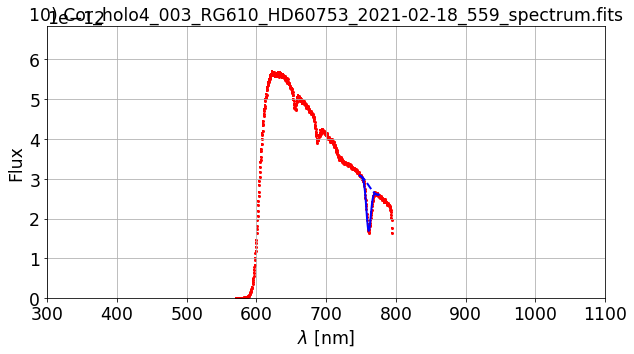

In [43]:
fig = plt.figure(figsize=(10,5))
plot_spectrum_simple(plt.gca(), s.lambdas, s.data, s.err)
lines.plot_detected_lines(plt.gca())
thetitle=str(IDXSEL)+") "+ filename_SEL
plt.title(thetitle)
plt.show()

In [44]:
lines.print_detected_lines()

<Table length=1>
  Line  Tabulated Detected   Shift   ...  Chisq   Eqwidth_mod Eqwidth_data
            nm       nm        nm    ... reduced       nm          nm     
bytes12  float32  float32   float32  ... float32    float32     float32   
------- --------- -------- --------- ... -------- ----------- ------------
            760.3 760.7885 0.4885408 ... 1.805199   3.1569176    3.1158347

## with specutils

### Convert in specutils units

In [45]:
lamb = 10*s.lambdas * u.AA 
flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10. 
fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

## Equivalent width calculation with Automatic line plot

In [46]:
def ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=None,ax2=None):
    """
    
    ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True)
    
    - input :
    
    
    - output :
    
    """
            
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
    
    eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
    eqw2=equivalent_width(cont_norm_spec, regions=sub_region)  
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\AA$ ".format(eqw1.value)
        eqw_str2="$Eqw_2$ = {:2.2f} $\AA$ ".format(eqw2.value)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline,color='r')
        ax1.axvline(wlmaxline,color="r")
        ax1.axvline(wlmin,color='g')
        ax1.axvline(wlmax,color="g")
        ax1.set_ylim(YMIN,YMAX)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline,color='r')
        ax2.axvline(wlmaxline,color="r")
        ax2.axvline(wlmin,color='g')
        ax2.axvline(wlmax,color="g")
        ax2.set_ylim(0,2)
        ax2.text(0.05, 0.95, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
        
    return eqw1.value,eqw2.value     

In [47]:
def ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=None,ax2=None):
    """
    
    ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline)
    
    - input :
    
    
    - output :
    
    """
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
         
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
       
    eqw10=equivalent_width(cont_norm_spec, regions=line_region).value 
    eqw20=equivalent_width(cont_norm_spec, regions=sub_region).value 
       
    # Bootstrap
    
    
    eqw1_set=np.zeros(NN)
    eqw2_set=np.zeros(NN)
    size=len(specerr.flux)
    
    # loop on trials 
    for idx in np.arange(NN):
        
        # random generator for errors
        s = np.random.normal(0, 1, size)
        
        # new flux
        newspec = Spectrum1D(spectral_axis=spec.spectral_axis, flux=spec.flux+specerr.flux*s)
              
    
        # region where one extract the spectrum
        sub_spectrum = extract_region(newspec, sub_region)
    
        # initialisaition of linear model
        g_init = models.Linear1D(slope=0,intercept=1e-12)
    
        # fit on sub-spectrum
        g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
        # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
        g2_fit = fit_continuum(newspec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
        y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
        y_continuum_fitted2 = g2_fit(newspec.spectral_axis)
    
        # normalize the spectrum
        cont_norm_spec = newspec/ y_continuum_fitted2 
    
    
        eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
        eqw2=equivalent_width(cont_norm_spec, regions=sub_region) 
        
        
        eqw1_set[idx]=eqw1.value
        eqw2_set[idx]=eqw2.value
        
     
    eqw1_std=eqw1_set.std()
    eqw2_std=eqw2_set.std()
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\pm$ {:2.2f} $\AA$ ".format(eqw10,eqw1_std)
        eqw_str2="$Eqw_2$ = {:2.2f} $\pm$ {:2.2f} $\AA$ ".format(eqw20,eqw2_std)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline,color='r')
        ax1.axvline(wlmaxline,color="r")
        ax1.axvline(wlmin,color='g')
        ax1.axvline(wlmax,color="g")
        ax1.set_ylim(YMIN,YMAX)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline,color='r')
        ax2.axvline(wlmaxline,color="r")
        ax2.axvline(wlmin,color='g')
        ax2.axvline(wlmax,color="g")
        ax2.set_ylim(0,2)
        ax2.text(0.05, 0.95, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
               
        
    return eqw10,eqw20,eqw1_set,eqw2_set     

### The original spectrum

#### O2 line

In [48]:
wlmin=10*(O2_1.wavelength-30)*u.AA
wlmax=10*(O2_1.wavelength+30)*u.AA
wlminline=10*(O2_1.wavelength-10)*u.AA
wlmaxline=10*(O2_1.wavelength+10)*u.AA

2021-04-29 11:51:33  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


Text(0.5, 0.98, '10) Cor_holo4_003_RG610_HD60753_2021-02-18_559_spectrum.fits')

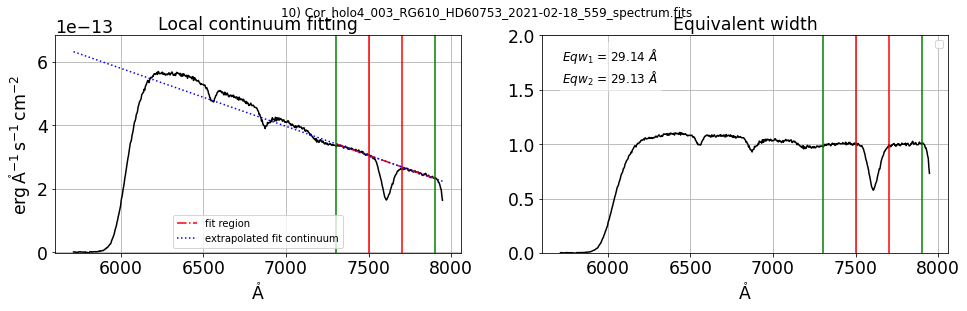

In [49]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

2021-04-29 11:51:36  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


Text(0.5, 0.98, '10) Cor_holo4_003_RG610_HD60753_2021-02-18_559_spectrum.fits')

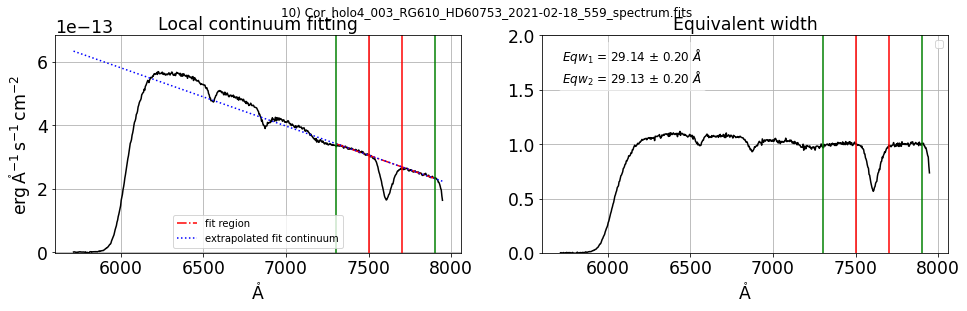

In [50]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=30,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

Text(0.5, 0.98, '10) Cor_holo4_003_RG610_HD60753_2021-02-18_559_spectrum.fits')

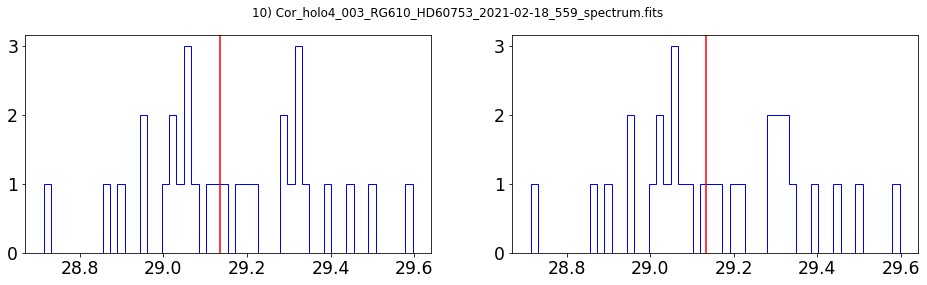

In [51]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(eq1_set,bins=50,histtype='step',color='b');
ax1.axvline(eqw10,color='r')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq2_set,bins=50,histtype='step',color="b");
ax2.axvline(eqw20,color='r')
plt.suptitle(thetitle)

### H2O line

In [52]:
wlmin=10*(H2O_1.wavelength-30)*u.AA
wlmax=10*(H2O_2.wavelength+30)*u.AA
wlminline=10*(H2O_1.wavelength-12)*u.AA
wlmaxline=10*(H2O_2.wavelength+10)*u.AA

In [53]:
lamb = 10*s.lambdas * u.AA 
flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10. 
fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

Exception: Spectrum flux is empty or None.

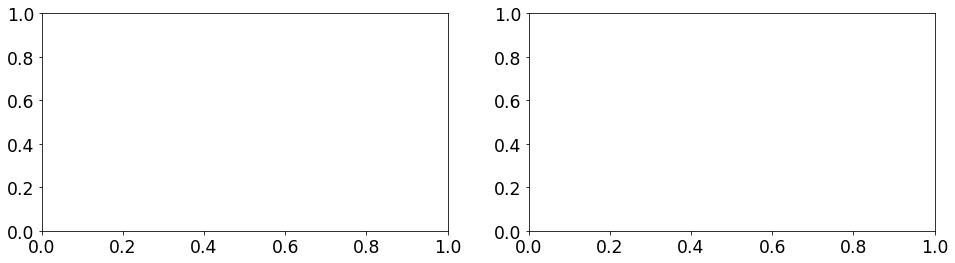

In [54]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=30,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(eq1_set,bins=50,histtype='step',color='b');
ax1.axvline(eqw10,color='r')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq2_set,bins=50,histtype='step',color='b');
ax2.axvline(eqw20,color='r')
plt.suptitle(thetitle)

# Loop on spectra with Spectractor

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


#for IDXSEL in np.arange(8,15):
for IDXSEL in np.array([9,10,12,13,35,36,37,38,39,40,41,42]):
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    s=Spectrum(fullfilename_SEL, config="config/auxtel_quicklook.ini")
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    #wlidx=np.where(np.logical_and( s.lambdas>=WLMIN, s.lambdas<=WLMAX))[0]
    #print(wlidx)
    #wl=s.lambdas[wlidx]
    
    #specify the lines  
    lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)
    s.lines = lines
    
    global_chisq = detect_lines(lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)
    
    print(IDXSEL,") ",filename_SEL)
    thetitle=str(IDXSEL)+") "+filename_SEL
    
    fig = plt.figure(figsize=(10,5))
    plot_spectrum_simple(plt.gca(), s.lambdas, s.data, s.err)
    lines.plot_detected_lines(plt.gca())
    plt.title(thetitle)
    plt.show()
    
    print(lines.print_detected_lines())
    print(lines.print_detected_lines()[0]["Eqwidth_data"])
    df_infos.at[IDXSEL,"eqw_o2_spec"] = lines.print_detected_lines()[0]["Eqwidth_data"]*10.
    
    

In [ ]:
print(lines.print_detected_lines())

In [ ]:
type(lines.print_detected_lines())

In [ ]:
print(lines.print_detected_lines()[0]["Eqwidth_data"])

In [ ]:
df_infos

# Loop on spectrum, compute O2 line equivalent width with specutils 

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


#for IDXSEL in np.arange(8,15):
for IDXSEL in np.array([9,10,12,13,35,36,37,38,39,40,41,42]):
    
    
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    
    print(IDXSEL,") ",filename_SEL)
    
    s=Spectrum(fullfilename_SEL, config="config/auxtel_quicklook.ini")
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    
    lamb = 10*s.lambdas * u.AA 
    flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
    specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)
    
    # O2 line
    wlmin=10*(O2_1.wavelength-30)*u.AA
    wlmax=10*(O2_1.wavelength+30)*u.AA
    wlminline=10*(O2_1.wavelength-10)*u.AA
    wlmaxline=10*(O2_1.wavelength+10)*u.AA
    
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    #eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
    eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=ax1,ax2=ax2)
    thetitle=str(IDXSEL)+") "+filename_SEL
    plt.suptitle(thetitle,y=1.01)
    plt.show() 
    
    print(IDXSEL,") eqw_O2=",eqw10)
    
    df_infos.at[IDXSEL,"eqw_o2"] =  eqw10

# Loop on spectrum, compute H2O line equivalent width with specutils 

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


#for IDXSEL in np.arange(8,15):
for IDXSEL in np.array([10,12,13,38,39,40,41,42]):
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    s=Spectrum(fullfilename_SEL, config="config/auxtel_quicklook.ini")
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    
    lamb = 10*s.lambdas * u.AA 
    flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
    specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)
    
    # H2O line
    
    wlmin=10*(H2O_1.wavelength-30)*u.AA
    wlmax=10*(H2O_2.wavelength+30)*u.AA
    wlminline=10*(H2O_1.wavelength-12)*u.AA
    wlmaxline=10*(H2O_2.wavelength+10)*u.AA
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    eqw1,eqw2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
    #eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=ax1,ax2=ax2)
    thetitle=str(IDXSEL)+") "+filename_SEL
    plt.suptitle(thetitle,y=1.01)
    plt.show() 
    
    print(IDXSEL,") eqw_O2=",eqw1)
    
    df_infos.at[IDXSEL,"eqw_h2o"] =  eqw1

In [ ]:
df_infos

In [ ]:
df_infos.to_csv("eqw.csv")

In [ ]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['eqw_o2'],marker="o",color="red",label="$eqw(O_2)$");
ax.plot(df_infos['date_obs'], df_infos['eqw_h2o'],marker="o",color="blue",label="$eqw(H_2O)$");
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="green",label="airmass")
ax2.set_ylim(1,1.5)
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax.set_title("Equivalent Widths vs date")

In [ ]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
df_infos.plot(ax=ax,x="date_obs", y=["eqw_o2","eqw_h2o"],color=["r","b"],marker="o");
#plt.gcf().autofmt_xdate(rotation=90) 
ax.xaxis.set_tick_params(rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax.set_yscale("log")

ax2 = ax.twinx()
df_infos.plot(ax=ax2,x="date_obs", y="airmass",color=["g"],marker="o",lw=0);
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax2.set_ylim(1,2)
ax2.xaxis.set_tick_params(rotation=90)
ax.set_title("Equivalent Widths vs date")


In [ ]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['reftime'], df_infos['eqw_o2'],marker="o",color="red",label="$eqw(O_2)$");
ax.plot(df_infos['reftime'], df_infos['eqw_h2o'],marker="o",color="blue",label="$eqw(H_2O)$");
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax2 = ax.twinx()
ax2.plot(df_infos['reftime'], df_infos['airmass'],linestyle='dotted', marker='.',color="green",label="airmass",lw=0)
ax2.set_ylim(1,1.5)
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax.set_title("Equivalent Widths vs date")